In [1]:
from obspy import read_events, Catalog, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geothermie_plot_function import *

In [2]:
threshold_event_magnitude = 0.5

In [3]:
catalog = read_events('Downloads/geothermie-events-master/geothermie-events-master/Unterhaching/*.xml')
catnew = Catalog()
cat2013 = Catalog()
eventinfo = []
eventinfo2 = []
for event in catalog:
    try:
        if not (event.origins[0]['time'] > UTCDateTime(2013,1,1) and event.origins[0]['time'] < UTCDateTime(2014,1,1)):
            catnew.append(event)
            eventinfo.append([event.origins[0]['time'],event.magnitudes[0].mag])
        else:
            cat2013.append(event)
            eventinfo2.append([event.origins[0]['time'],event.magnitudes[0].mag])
    except:
        pass
catalog = catnew
roundedtimes = []
magnitudes = []
for time in eventinfo:
    rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
    roundedtimes.append(rtime)
    magnitudes.append(time[1])
roundedtimes, magnitudes = zip(*sorted(zip(roundedtimes, magnitudes)))
print(catalog)
names = 'Time,Flowrate,Temperature,Pressure'
names = names.split(",")
data = pd.read_csv('Dokumente/unterhaching_betriebsdaten_2008-2017/daten20082017.txt',names=names,skiprows=1,delimiter=' ')
N = len(data)
newcol = np.zeros(N)
newcol2 = np.zeros(N)
flc = np.zeros(N)
tc = np.zeros(N)
pc = np.zeros(N)

ievent = 0

eventtimes = np.zeros(N)
eventtimes[0] = 100*365*24
eventtimes[1] = eventtimes[0]+1
newcol2[0] = np.nan
for i in range(1,N):
    if data['Time'][i] in roundedtimes:
        newcol[i] = 1
        N_events_in_this_hour = roundedtimes.count(data['Time'][i])
        
        ## get top magnitude of events in this hour
        mag = max(magnitudes[ievent:ievent+N_events_in_this_hour])
        newcol2[i] = mag
        if mag > threshold_event_magnitude:
            eventtimes[i+1] = 0
        else:
            eventtimes[i+1] = eventtimes[i]+1
        
        ievent += N_events_in_this_hour
    else:
        newcol2[i] = np.nan
        if i!=N-1:
            eventtimes[i+1] = eventtimes[i]+1
        
            
    
    if i==43022:
        roundedtimes2 = []
        magnitudes2 = []
        for time in eventinfo2:
            rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
            roundedtimes2.append(rtime)
            magnitudes2.append(time[1])
        roundedtimes2, magnitudes2 = zip(*sorted(zip(roundedtimes2, magnitudes2)))
        roundedtimes2 = list(roundedtimes2)
        magnitudes2 = list(magnitudes2)
        roundedtimes2.reverse()
        magnitudes2.reverse()
        check = True
        mag = -100
        eventindex = -1
        while (mag < threshold_event_magnitude and check):
            eventindex += 1
            mag = magnitudes2[eventindex]
            if eventindex==len(magnitudes2):
                check = False
        eventtimes[i] = (float(UTCDateTime(2014,1,1))-roundedtimes2[eventindex])/(60**2)

drop = []
for i in range(N):
    if np.isnan(data['Flowrate'][i]):
        drop.append(i)
data.drop(drop)
N = len(data)

for i in range(1,N-1):
    flc[i] = data['Flowrate'][i+1]-data['Flowrate'][i-1]
    tc[i] = data['Temperature'][i+1]-data['Temperature'][i-1]
    pc[i] = data['Pressure'][i+1]-data['Pressure'][i-1]
    

#data['Flowrate diff'] = flc/2
#data['Temp diff'] = tc/2
#data['Press diff'] = pc/2
data['Quiet time'] = eventtimes
data['Event'] = newcol
data['Magnitude'] = newcol2
names.extend(['Flowrate diff','Temp diff','Press diff','Quiet time','Event','Magnitude'])

509 Event(s) in Catalog:
2010-05-27T16:25:25.312700Z | +48.048,  +11.644 | 0.0839474806054 Ml
2010-01-31T08:00:57.025500Z | +48.048,  +11.643 | 0.039033276658 Ml
...
2019-01-18T21:53:12.483393Z | +48.049,  +11.646 | -0.472072504528 None
2019-12-31T17:47:30.953434Z | +48.045,  +11.644 | -0.497145528261 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [4]:
def Confusionmatrix(y,yhat,perc):
    N = len(y)
    C = [[0,0],[0,0]]
    for i in range(N):
        if y[i,0]==1. and yhat[i,0]>=perc:
            C[0][0] += 1
        elif y[i,0]==0. and yhat[i,0]>=perc:
            C[1][0] += 1
        elif y[i,0]==1. and yhat[i,0]<perc:
            C[0][1] += 1
        else:
            C[1][1] += 1
            
    print('True Positives:  ', C[0][0])
    print('False Positives: ', C[1][0])
    print('False Negatives: ', C[0][1])
    print('True Negatives:  ', C[1][1])
    return C

In [5]:
def plot_model_evolution(Loss,b,c,U,V,W):
    fig,ax = plt.subplots(nrows=6,figsize=(15,15),sharex=True)
    ax[0].plot(Loss,label='Loss')
    ax[0].set_yscale('log')
    ax[1].plot(c[:,0],label='c1')
    ax[1].plot(c[:,1],label='c2')
    ax[2].plot(b[:,0],label='b1')
    ax[2].plot(b[:,1],label='b2')
    ax[2].plot(b[:,2],label='b3')
    ax[3].plot(V[:,0,0],label='V11')
    ax[3].plot(V[:,0,1],label='V12')
    ax[3].plot(V[:,0,2],label='V13')
    ax[3].plot(V[:,1,0],label='V21')
    ax[3].plot(V[:,1,1],label='V22')
    ax[3].plot(V[:,1,2],label='V23')
    
    ulabels = [['U11','U12','U13'],['U21','U22','U23'],['U31','U32','U33']]
    wlabels = [['W11','W12','W13'],['W21','W22','W23'],['W31','W32','W33']]
    
    for i in range(3):
        for j in range(3):
            ax[4].plot(U[:,i,j],label=ulabels[i][j])
            ax[5].plot(W[:,i,j],label=wlabels[i][j])
            
    for i in range(6):
        ax[i].legend(fontsize=8)
    plt.show() 

In [6]:
def softmax(xx):
    z = np.zeros(len(xx))
    summa = 0
    for i in range(len(xx)):
        z[i] = np.exp(xx[i])
        summa += np.exp(xx[i])
    return z/summa

In [7]:
def ReLu(xx):
    zz = np.zeros(len(xx))
    for i in range(len(xx)):
        if xx[i]>0:
            zz[i] = xx[i]
    return zz

In [8]:
def delta(xx,yy):
    if xx==yy:
        return 1.
    else:
        return 0.

In [17]:
def initialization(Nit):

    U = np.zeros((Nit,4,4))
    W = np.zeros((Nit,4,4))
    b = np.zeros((Nit,4))
    V = np.zeros((Nit,2,4))
    c = np.zeros((Nit,2))

    dU = np.zeros((Nit,4,4))
    dW = np.zeros((Nit,4,4))
    db = np.zeros((Nit,4))
    dV = np.zeros((Nit,2,4))
    dc = np.zeros((Nit,2))

    yhat = np.zeros((Nit+1,N,2))

    Nrandom = 1000

    for i in range(4):
        for j in range(4):
            U[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom  
            W[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom  
        b[0,i]= (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom   
    for i in range(2):
        for k in range(4):
            V[0,i,k] =(np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
        c[0,i] =(np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom      

    Loss = np.zeros(Nit)

    return U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss

In [13]:
def prediction(b,c,U,V,W,x):
    N = len(x)
    a = np.zeros((N,4))
    h = np.zeros((N,4))
    o = np.zeros((N,2))
    yhat = np.zeros((N,2))
    a[0] = b + np.dot(U,x[0])
    h[0] = np.tanh(a[0])
    o[0] = c + np.dot(V,h[0])
    for t in range(0,N):
        a[t] = b + np.dot(W,h[t-1])+np.dot(U,x[t])
        h[t] = np.tanh(a[t])
        o[t] = c + np.dot(V,h[t])
        yhat[t,:] = softmax(o[t,:])
    return h,o,yhat

def get_loss(y,yhat):
    N = len(y)
    Loss = 0
    for t in range(N):
        Loss -= y[t,0]*np.log10(yhat[t,0])+(1-y[t,0])*np.log10(yhat[t,1])
    return Loss

def gradients(h,o,V,W,x,y,yhat):
    N = len(x)
    do = np.zeros((N,2))
    for t in range(N):
        do[t,0] = y[t,0]*(1-yhat[t,0])-yhat[t,0]*(1-y[t,0])
        do[t,1] = -y[t,0]*yhat[t,1] * (1-y[t,0])*(1-yhat[t,1])
    do /= np.log(10)
    
    dh = np.zeros((N,4))
    dh[-1] = np.dot(V.transpose(),do[-1])
    for t in range(N-2,-1,-1):
        diag = np.diag(np.array([1-h[t+1,0]**2,1-h[t+1,1]**2,1-h[t+1,2]**2,1-h[t+1,3]**2]))
        dh[t] = np.dot(np.dot(W.transpose(),diag),dh[t+1])+np.dot(V.transpose(),do[t])

    dc = np.zeros(2)
    for i in range(2):
        dc[i] = np.sum(do[:,i])
    db = np.zeros(4)
    dV = np.zeros((2,4))
    dW = np.zeros((4,4))
    dU = np.zeros((4,4))
    for i in range(4):
        for t in range(N):
            db[i] += (1-h[t,i]**2)*dh[t,i]
    
    for t in range(N):
        for i in range(2):
            for j in range(4):
                dV[i,j] += do[t,i]*h[t,j]


    for t in range(1,N):
        mat = np.zeros((4,4))
        mat2 = np.zeros((4,4))
        for i in range(4):
            for j in range(4):
                mat[i,j] = dh[t,i] * h[t-1,j]
                mat2[i,j] = dh[t,i] * x[t,j]
        dW += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2,1-h[t,3]**2])),mat)
        dU += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2,1-h[t,3]**2])),mat2)
    return db,dc,do,dU,dV,dW

In [11]:
def mapx(x):
    Nt, Ni = np.shape(x)
    m = np.zeros((Ni,2))
    for i in range(Ni):
        m[i,0] = np.min(x[:,i])
        m[i,1] = np.max(x[:,i])
    newx = np.zeros(np.shape(x))
    for i in range(Ni):
        for t in range(Nt):
            newx[t,i] = (x[t,i]-m[i,0])/(m[i,1]-m[i,0])
    return newx

In [25]:
#data acquisition
N = len(data)
x = [[],[],[],[]]
y = [[],[]]
index = 0
for i in range(N):
    if not np.isnan(data['Flowrate'][i]):
        x[0].append(data['Flowrate'][i])
        x[1].append(data['Temperature'][i])
        x[2].append(data['Pressure'][i])
        x[3].append(np.log10(data['Quiet time'][i]+1))
        y[0].append(data['Event'][i])
        y[1].append(data['Magnitude'][i])
x = np.array(x).transpose()
y = np.array(y).transpose()
x = mapx(x)
N = len(x)

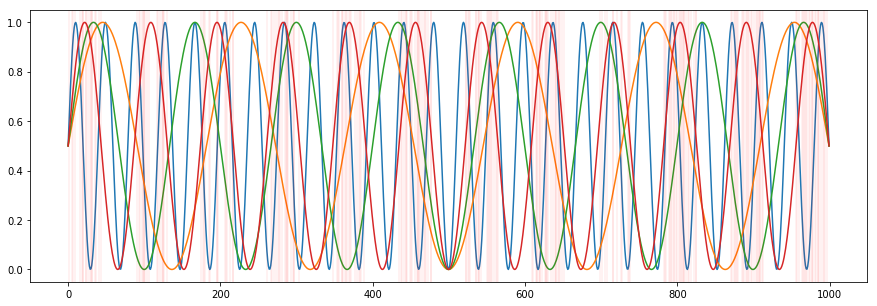

In [15]:
#fake data
N = 1000
x = np.zeros((N,4))
y = np.zeros((N,2))
x[:,0] = (np.sin(np.linspace(0,51*np.pi,N))+1)/2
x[:,1] = (np.sin(np.linspace(0,11*np.pi,N))+1)/2
x[:,2] = (np.sin(np.linspace(0,15*np.pi,N))+1)/2
x[:,3] = (np.sin(np.linspace(0,23*np.pi,N))+1)/2
plt.figure(figsize=(15,5))
plt.plot(x[:,0])
plt.plot(x[:,1])
plt.plot(x[:,2])
plt.plot(x[:,3])
xx = []
yy = []
for i in range(N):
    if x[i,3]>0.5 and np.random.randint(2)>0:
        y[i,0] = 1.
        xx.append(i)
        yy.append(np.max(x[i,0]))
        plt.axvline(i,lw=0.1,c='r')
#plt.scatter(xx,yy,c='r',marker='X')
plt.show()
x = mapx(x)

### RNN-model, fig. 10.4, additionally utilizing Quiet time as input parameter

-- Doesn't improve the model a bit

In [26]:
Nit = 1000
eps = 0.001

U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss = initialization(Nit)

for k in range(Nit):
    h,o,yhat[k] = prediction(b[k],c[k],U[k],V[k],W[k],x)
    Loss[k] = get_loss(y,yhat[k])
    print(k,Loss[k])
    db[k],dc[k],do,dU[k],dV[k],dW[k] = gradients(h,o,V[k],W[k],x,y,yhat[k])
    
    if k+1<Nit:
        U[k+1] = U[k] + eps*dU[k]
        W[k+1] = W[k] + eps*dW[k]
        V[k+1] = V[k] + eps*dV[k]
        b[k+1] = b[k] + eps*db[k]
        c[k+1] = c[k] + eps*dc[k]

    

0 22654.3442006
1 10733.288789
2 10613.0969496
3 10492.9051102
4 10372.7132709
5 10252.5214315
6 10132.3295921
7 10012.1377528
8 9891.94591343
9 9771.75407407
10 9651.56223471
11 9531.37039536
12 9411.178556
13 9290.98671665
14 9170.7948773
15 9050.60303794
16 8930.41119859
17 8810.21935924
18 8690.02751989
19 8569.83568054
20 8449.6438412
21 8329.45200185
22 8209.2601625
23 8089.06832316
24 7968.87648381
25 7848.68464447
26 7728.49280512
27 7608.30096578
28 7488.10912644
29 7367.9172871
30 7247.72544776
31 7127.53360842
32 7007.34176908
33 6887.14992974
34 6766.9580904
35 6646.76625106
36 6526.57441173
37 6406.38257239
38 6286.19073306
39 6165.99889372
40 6045.80705439
41 5925.61521505
42 5805.42337572
43 5685.23153639
44 5565.03969706
45 5444.84785773
46 5324.6560184
47 5204.46417907
48 5084.27233974
49 4964.08050041
50 4843.88866108
51 4723.69682175
52 4603.50498243
53 4483.31314311
54 4363.12130381
55 4242.92946451
56 4122.73762527
57 4002.54578612
58 3882.35394717
59 3762.16210867

465 978.440942583
466 978.440942582
467 978.440942582
468 978.440942582
469 978.440942582
470 978.440942582
471 978.440942582
472 978.440942582
473 978.440942582
474 978.440942582
475 978.440942582
476 978.440942582
477 978.440942582
478 978.440942581
479 978.440942581
480 978.440942581
481 978.440942581
482 978.440942581
483 978.440942581
484 978.440942581
485 978.440942581
486 978.440942581
487 978.440942581
488 978.440942581
489 978.44094258
490 978.44094258
491 978.44094258
492 978.44094258
493 978.44094258
494 978.44094258
495 978.44094258
496 978.44094258
497 978.44094258
498 978.44094258
499 978.44094258
500 978.44094258
501 978.440942579
502 978.440942579
503 978.440942579
504 978.440942579
505 978.440942579
506 978.440942579
507 978.440942579
508 978.440942579
509 978.440942579
510 978.440942579
511 978.440942579
512 978.440942579
513 978.440942578
514 978.440942578
515 978.440942578
516 978.440942578
517 978.440942578
518 978.440942578
519 978.440942578
520 978.440942578
521 

923 978.440942543
924 978.440942543
925 978.440942543
926 978.440942543
927 978.440942543
928 978.440942542
929 978.440942542
930 978.440942542
931 978.440942542
932 978.440942542
933 978.440942542
934 978.440942542
935 978.440942542
936 978.440942542
937 978.440942542
938 978.440942542
939 978.440942541
940 978.440942541
941 978.440942541
942 978.440942541
943 978.440942541
944 978.440942541
945 978.440942541
946 978.440942541
947 978.440942541
948 978.440942541
949 978.440942541
950 978.440942541
951 978.44094254
952 978.44094254
953 978.44094254
954 978.44094254
955 978.44094254
956 978.44094254
957 978.44094254
958 978.44094254
959 978.44094254
960 978.44094254
961 978.44094254
962 978.440942539
963 978.440942539
964 978.440942539
965 978.440942539
966 978.440942539
967 978.440942539
968 978.440942539
969 978.440942539
970 978.440942539
971 978.440942539
972 978.440942539
973 978.440942539
974 978.440942538
975 978.440942538
976 978.440942538
977 978.440942538
978 978.440942538
979

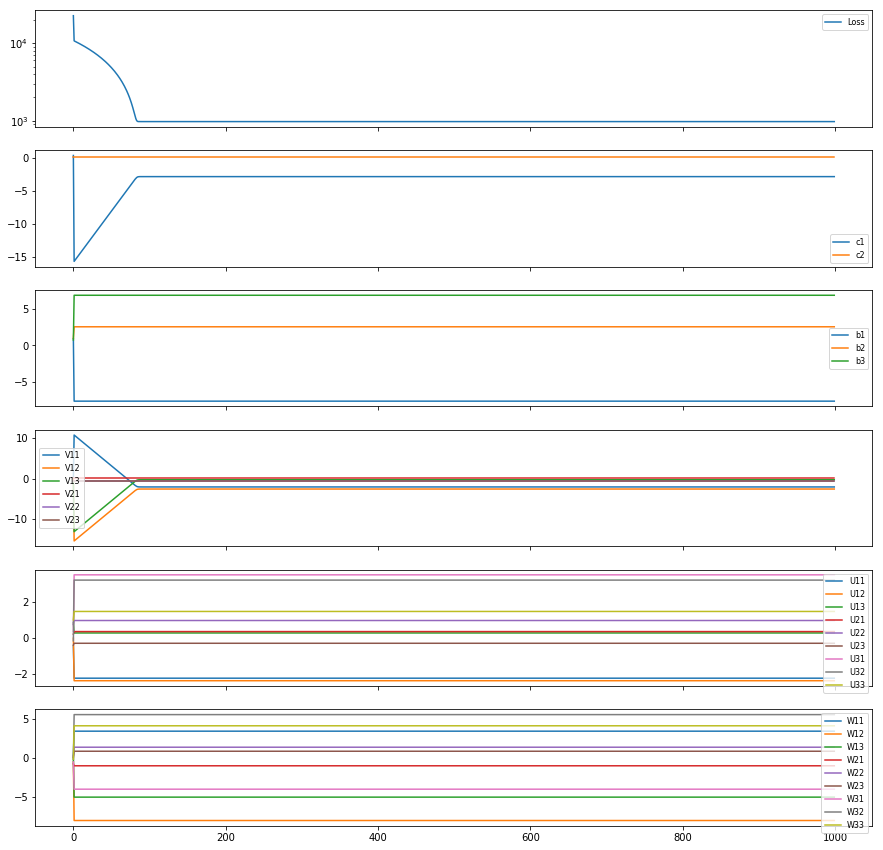

In [27]:
plot_model_evolution(Loss,b,c,U,V,W)

In [28]:
_,_,pred = prediction(b[-1],c[-1],U[-1],V[-1],W[-1],x)

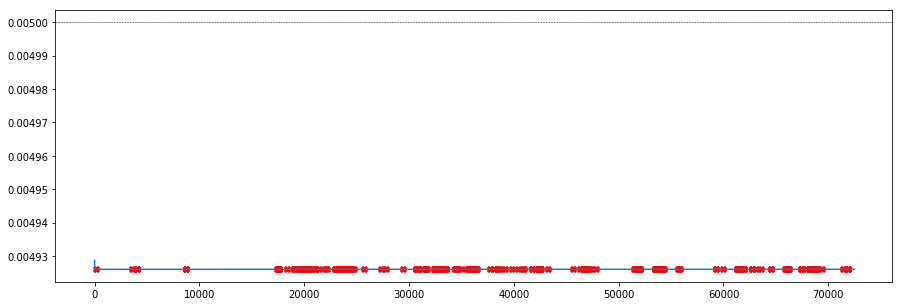

True Positives:   0
False Positives:  0
False Negatives:  357
True Negatives:   72116


In [29]:
q = 0.005

plt.figure(figsize=(15,5))
plt.plot(pred[:,0])
for i in range(N):
    if y[i,0]==1.:
        plt.scatter(i,pred[i,0],c='r',marker='X')
plt.axhline(q,lw=0.5,ls='dashed',c='k')
#plt.yscale('log')
plt.show()

C = Confusionmatrix(y,pred,q)